In [80]:
import csv
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_absolute_error
from numpy.linalg import pinv # pseudo-inverse

In [81]:
#read each element of the csv file, separate by commas as a row and put it in a list
path = 'dataset/solar_data.csv'

with open(path, 'r') as file:
    reader = csv.reader(file)
    data = list(reader)
    

In [82]:
data=np.array(data)
data=data.squeeze()

In [83]:
#convert data float
data = data.astype(float)

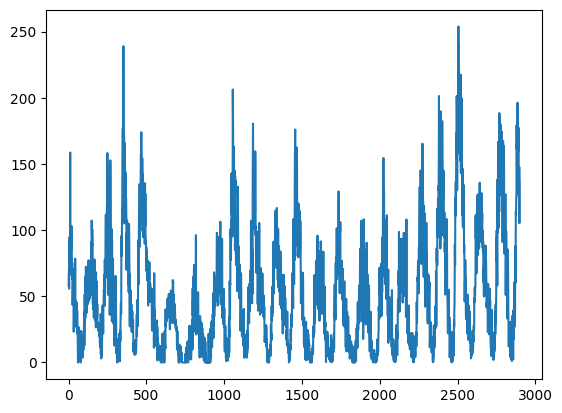

In [84]:
plt.plot(data)

In [320]:
class LSM():
    
    def __init__(self,  N_exc, N_inib, w_in_exc, w_in_inib, w_rec_exc, w_rec_inib, sigma=0.1 ):
        re = np.random.rand(N_exc)
        ri = np.random.rand(N_inib)
        # parameters of the iziechevic dynamic
        self.a = np.concatenate((0.02*np.ones(N_exc), 0.02+0.08*ri))
        self.b = np.concatenate((0.2*np.ones(N_exc), 0.25-0.05*ri))
        self.c = np.concatenate((-65+15*re**2, -65*np.ones(N_inib)))
        self.d = np.concatenate((8-6*re**2, 2*np.ones(N_inib)))
        # weights
        self.in_weights =\
              np.concatenate((w_in_exc*np.ones(N_exc), w_in_inib*np.ones(N_inib))) \
            + np.random.randn(N_exc + N_inib) * sigma
        
        self.rec_weights =np.concatenate([w_rec_exc*np.ones((N_exc + N_inib, N_exc)), -w_rec_inib*np.ones((N_exc+ N_inib, N_inib))], axis=1)  
        self.rec_weights+= np.random.randn(N_exc + N_inib, N_exc + N_inib)* sigma

        # initial states
        self.u = -65*np.ones(N_exc+N_inib)  # Initial values of u
        self.w = self.b*self.u  # Initial values of w
        # outputs of the simulation
        
    def simulate(self, inputs,  bool_states=True):
       
    
        self.firings = []  # spike timings
        self.states = []  # here we construct the matrix of reservoir states
        for t, input in enumerate(inputs):
            I = input * self.in_weights
            fired = np.where(self.u >= 30)[0]  # indices of spikes
            self.u[fired] = self.c[fired] # reset potential for neurons that fired
            self.w[fired] = self.w[fired] + self.d[fired] # reset recovery for neurons that fired
            I = I + np.sum(self.rec_weights[:, fired], axis=1) # add the recurring input from the neurons that fired
            
            self.u = self.u + 0.5*(0.04*self.u**2 + 5*self.u + 140 - self.w + I)  # step 0.5 ms
            self.u = self.u + 0.5*(0.04*self.u**2 + 5*self.u + 140 - self.w + I)  # for numerical stability
            self.w = self.w + self.a*(self.b*self.u - self.w)
            
            # save the firings and states for the last epoch 
        
            self.firings.append(np.column_stack((t+np.zeros_like(fired), fired)))

            if bool_states:
                self.states.append(self.u >= 30)
            else:
                self.states.append(self.u)

        self.firings = np.concatenate(self.firings)
        self.states=np.array(self.states)
        return self.states, self.firings
    

    

In [321]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [322]:
class ContinuousLSM(LSM):
        
        def __init__(self, N_exc, N_inib, w_in_exc, w_in_inib, w_rec_exc, w_rec_inib,sigma):
            super().__init__(N_exc, N_inib, w_in_exc, w_in_inib, w_rec_exc, w_rec_inib, sigma)
           
            
        def simulate(self, inputs, bool_states=True):
            self.firings = []  # spike timings
            self.states = []  # here we construct the matrix of reservoir states
            for t, input in enumerate(inputs):
                I = input * self.in_weights
                fired = np.where(self.u >= 30)[0]  # indices of spikes
                self.u[fired] = self.c[fired] # reset potential for neurons that fired
                self.w[fired] = self.w[fired] + self.d[fired] # reset recovery for neurons that fired
                # normalize u in [0,1]

                u_scaled = scaler.fit_transform(self.u.reshape(-1, 1)).squeeze()
                rec_output = self.rec_weights @ u_scaled
                
                I = I + rec_output # add the recurring input from the neurons that fired
                
                self.u = self.u + 0.5*(0.04*self.u**2 + 5*self.u + 140 - self.w + I)  # step 0.5 ms
                self.u = self.u + 0.5*(0.04*self.u**2 + 5*self.u + 140 - self.w + I)  # for numerical stability
                self.w = self.w + self.a*(self.b*self.u - self.w)
                
                # save the firings and states for the last epoch 
                
                self.firings.append(np.column_stack((t+np.zeros_like(fired), fired)))

                if bool_states:
                    self.states.append(self.u >= 30)
                else:
                    self.states.append(u_scaled)
            self.firings = np.concatenate(self.firings)
            self.states=np.array(self.states)
            return self.states, self.firings
    


In [249]:
input_dataset =data[:-1]
target_dataset= data[1:]

In [250]:
# split inputs and targets in train/test
input_train = input_dataset[:-500]
input_test = input_dataset[-500:]
target_train =target_dataset[:-500]
target_test = target_dataset[-500:]

In [251]:
print(input_train.shape)

(2398,)


In [252]:
# split training data in train/val for model selection
input_val = input_train[-300:]
input_train=input_train[:-300]
target_val = target_train[-300:]
target_train=target_train[:-300]

In [253]:
input_train.shape

(2098,)

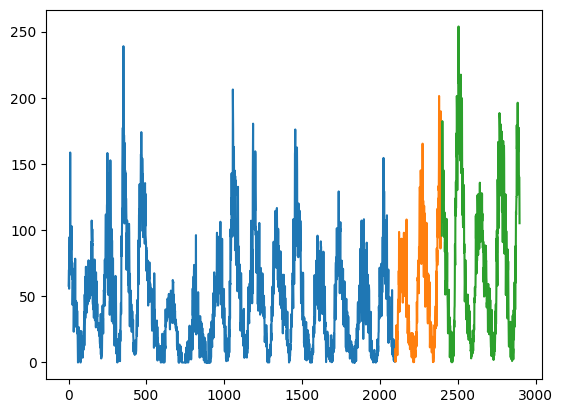

In [254]:
plt.plot(np.arange(0, len(input_train)) ,input_train)
plt.plot(np.arange(len(input_train), len(input_train)+len(input_val)), input_val)
plt.plot(np.arange(len(input_train)+len(input_val), len(input_train)+len(input_val)+len(input_test)), input_test)

(1000, 1000)


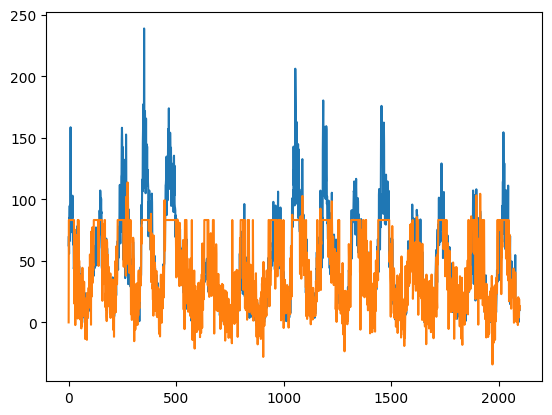

(1, 2098)
(2098,)


17.21440924738475

In [296]:
continuous_lsm = ContinuousLSM(600, 400, 5,2 ,0.5, 1, sigma =0.1)
train_states, _ = continuous_lsm.simulate(input_train,  bool_states=False)
   
readout = np.matmul(target_train.reshape(1, -1), pinv(train_states).T)

# predict training

pred_train = readout @ train_states.T
plt.plot(target_train)
plt.plot(pred_train.T)
plt.show()
print(pred_train.shape)
print(target_train.shape)
mean_absolute_error(pred_train.squeeze(), target_train)

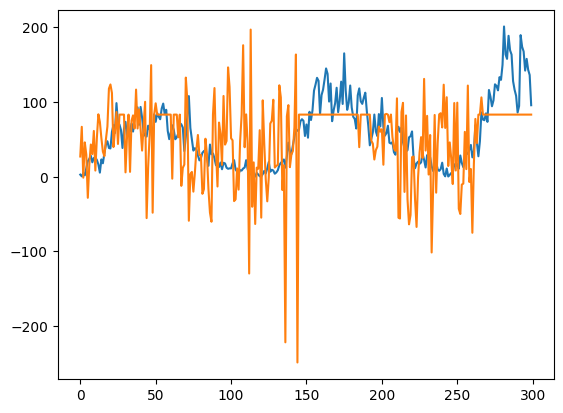

41.36617989838856

In [297]:
# predict validation
val_states ,_ = continuous_lsm.simulate(input_val, bool_states=False)
pred_val = readout @ val_states.T
plt.plot(target_val)
plt.plot(pred_val.T)
plt.show()
mean_absolute_error(pred_val.squeeze(), target_val)



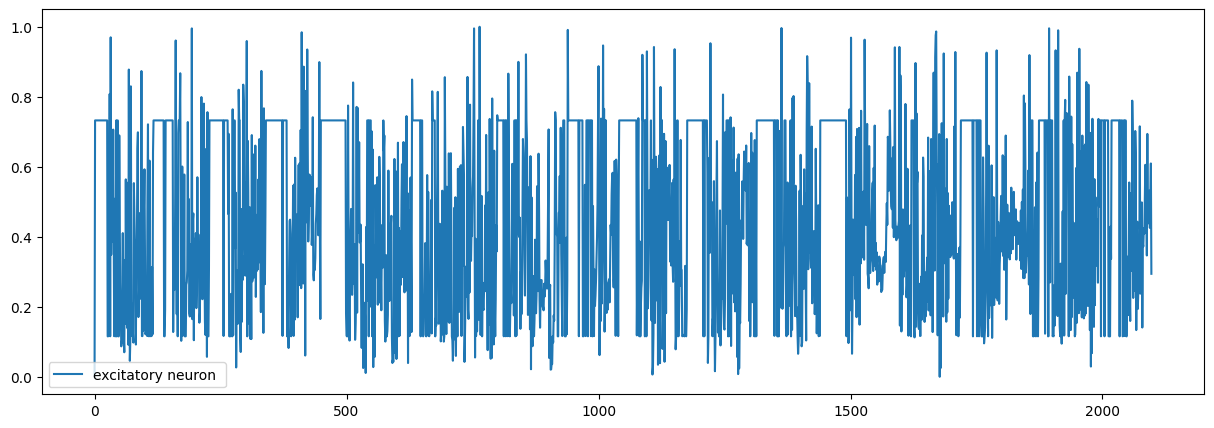

In [298]:
# plot the reservoir states
plt.figure(figsize=(15, 5))
plt.plot(train_states[:,1], label='excitatory neuron ')
#plt.plot(train_states[:,-1], label='inhibitory neuron ')
plt.legend()
plt.show()

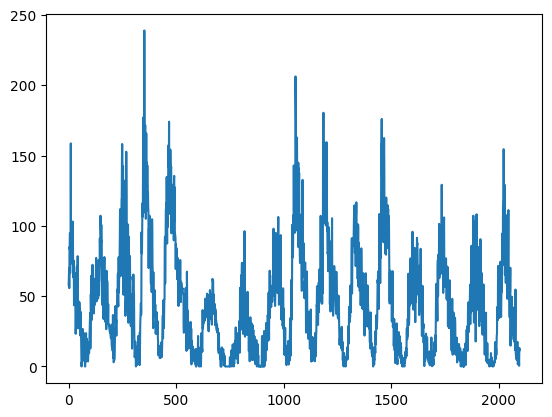

In [291]:
plt.plot(input_train)

In [ ]:
from tqdm import tqdm
# grid search for the best hyperparameters
best_error = np.inf
best_params = None
from itertools import product
N_exc = [400, 600, 800]
N_inib = [200, 400, 600]
w_in_exc = [2, 5, 10]
w_in_inib = [1, 2, 5]
w_rec_exc = [0.5, 1, 2]
w_rec_inib = [0.5, 1, 2]
bool_states = [True, False]
#sigma = [0.1, 0.2, 0.5]

#make a grid search for the best hyperparameters with progress bar


loop = tqdm(total=len(list(product(N_exc, N_inib, w_in_exc, w_in_inib, w_rec_exc, w_rec_inib, bool_states))), position=0, leave=False)

for N_exc_, N_inib_, w_in_exc_, w_in_inib_, w_rec_exc_, w_rec_inib_ in product(N_exc, N_inib, w_in_exc, w_in_inib, w_rec_exc, w_rec_inib):
    continuous_lsm = ContinuousLSM(N_exc_, N_inib_, w_in_exc_, w_in_inib_, w_rec_exc_, w_rec_inib_, sigma =0.1)
    train_states, _ = continuous_lsm.simulate(input_train,  bool_states=bool_states)
    readout = np.matmul(target_train.reshape(1, -1), pinv(train_states).T)
    val_states ,_ = continuous_lsm.simulate(input_val, bool_states=bool_states)
    pred_val = readout @ val_states.T
    error = mean_absolute_error(pred_val.squeeze(), target_val)
    if error < best_error:
        best_error = error
        best_params = (N_exc_, N_inib_, w_in_exc_, w_in_inib_, w_rec_exc_, w_rec_inib_)
    loop.set_description(f'Best error: {best_error:.2f}')
    loop.update(1)
        

In [ ]:
from tqdm import tqdm
# grid search for the best hyperparameters
best_error = np.inf
best_params = None
from itertools import product
N_exc = [600, 400]
N_inib = [400, 200]
w_in_exc = [2, 5]
w_in_inib = [1, 2]
w_rec_exc = [0.5, 1]
w_rec_inib = [0.5, 1]
bool_states = [True, False]
#sigma = [0.1, 0.2, 0.5]

#make a grid search for the best hyperparameters with progress bar


loop = tqdm(total=len(list(product(N_exc, N_inib, w_in_exc, w_in_inib, w_rec_exc, w_rec_inib, bool_states))), position=0, leave=False)

for N_exc_, N_inib_, w_in_exc_, w_in_inib_, w_rec_exc_, w_rec_inib_, bool_states in product(N_exc, N_inib, w_in_exc, w_in_inib, w_rec_exc, w_rec_inib, bool_states):
    lsm = LSM(N_exc_, N_inib_, w_in_exc_, w_in_inib_, w_rec_exc_, w_rec_inib_, sigma =0.1)
    train_states, _ = lsm.simulate(input_train,  bool_states=bool_states)
    readout = np.matmul(target_train.reshape(1, -1), pinv(train_states).T)
    val_states ,_ = lsm.simulate(input_val, bool_states=bool_states)
    pred_val = readout @ val_states.T
    error = mean_absolute_error(pred_val.squeeze(), target_val)
    if error < best_error:
        best_error = error
        best_params = (N_exc_, N_inib_, w_in_exc_, w_in_inib_, w_rec_exc_, w_rec_inib_)
    loop.set_description(f'Best error: {best_error:.2f}')
    loop.update(1)

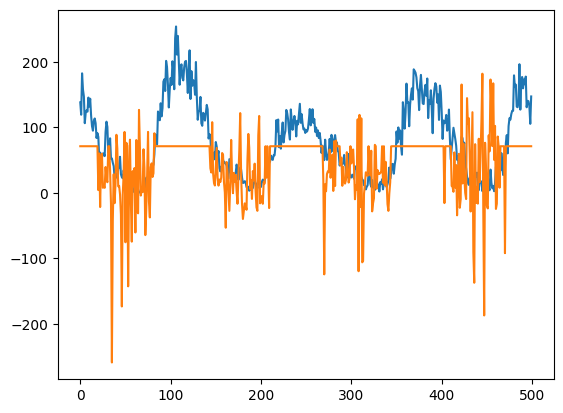

error: 51.658941937288155


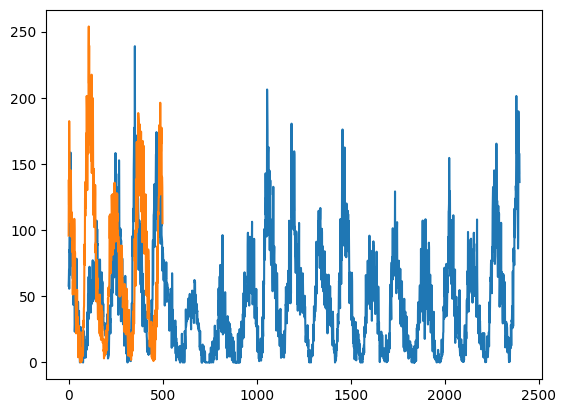

In [316]:
# test the best model
continuous_lsm = ContinuousLSM(*best_params, sigma =0.1)
input_train_final = np.concatenate((input_train, input_val))
target_train_final = np.concatenate((target_train, target_val))
train_states, _ = continuous_lsm.simulate(input_train_final,  bool_states=False)
readout = np.matmul(target_train_final.reshape(1, -1), pinv(train_states).T)

test_states ,_ = continuous_lsm.simulate(input_test, bool_states=False)
pred_test = readout @ test_states.T
plt.plot(target_test)
plt.plot(pred_test.T)
plt.show()
print('error:', mean_absolute_error(pred_test.squeeze(), target_test))




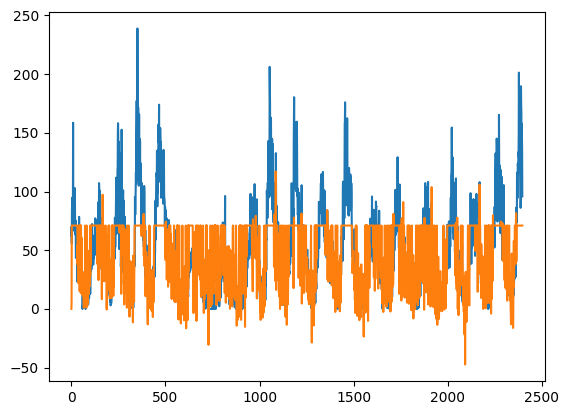

training error: 22.873485389729865


In [319]:
plt.plot(target_train_final)
pred_train_final = readout @ train_states.T
plt.plot(pred_train_final.T)
plt.show()
print('training error:', mean_absolute_error(pred_train_final.squeeze(), target_train_final))

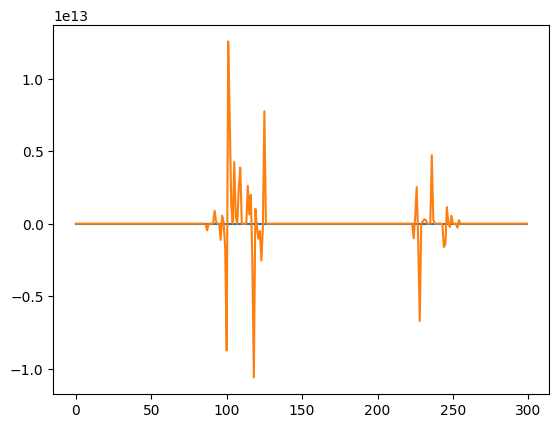

In [330]:
lsm= ContinuousLSM(N_exc=500, N_inib=200, w_in_exc= 5, w_in_inib= 2, w_rec_exc= 0.5, w_rec_inib=1, sigma =0.1)
train_states, _ = lsm.simulate(input_train,  bool_states=False)
readout = np.matmul(target_train.reshape(1, -1), pinv(train_states).T)
val_states ,_ = lsm.simulate(input_val, bool_states=False)
pred_val = readout @ val_states.T
plt.plot(target_val)
plt.plot(pred_val.T)
plt.show()
